In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go



from concurrent.futures import ThreadPoolExecutor
import random

from sklearn.preprocessing import MinMaxScaler, StandardScaler #only used MinMAx and seems to work better
from sklearn.decomposition import PCA # I tried PCA but didn't spend much time on it. The reduced version had no visualizaiton benefits
from sklearn.manifold import TSNE

from scipy.ndimage import gaussian_filter


import librosa
import librosa.display
import noisereduce as nr


from scipy.signal import butter, filtfilt, iirnotch
from scipy.io.wavfile import write

/home/amir/anaconda3/envs/tf/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
root_dir = "~/Documents/Data/Birds/2021/"

spectrograms = []
labels = []

locations = ["BRY", "CAL", "FIO", "HAR", "KEA", "LAW", "LIF", "MCK", "PEN", "SYL", "WAT"]

def process_file(args):
    spec_path, label_row = args
    spec_data = pd.read_csv(spec_path, header=None).values 
    return spec_data, label_row[1:].values  

for location in locations:
    location_dir = os.path.join(root_dir, location)
    spec_dir = os.path.join(location_dir, "SPEC")
    labels_file = os.path.join(location_dir, "train_labels.csv")
    
    labels_df = pd.read_csv(labels_file)
    
    tasks = []
    for _, row in labels_df.iterrows():
        fname = row['fname'].replace(".mp3", ".csv")  
        spec_path = os.path.join(spec_dir, fname)
        tasks.append((spec_path, row)) 

    
    with ThreadPoolExecutor(max_workers=8) as executor:
        results = list(executor.map(process_file, tasks))
    

    for spec_data, label_data in results:
        spectrograms.append(spec_data)
        labels.append(label_data)

spectrograms = np.array(spectrograms)
labels = np.array(labels)

print(f"Spectrograms shape: {spectrograms.shape}") 
print(f"Labels shape: {labels.shape}") 

In [ ]:
np.save("spectrograms.npy", spectrograms)
np.save("labels.npy", labels)

# Start from here if you downloaded my npy files

In [59]:
spectrograms_path = os.path.expanduser("~/Documents/Code/Bird Classification/spectrograms-3.npy")
labels_path = os.path.expanduser("~/Documents/Code/Bird Classification/labels-3.npy")
root_dir = "~/Documents/Data/Birds/2021/"

spectrograms = np.load(spectrograms_path)
labels = np.load(labels_path,allow_pickle=True)

In [60]:
print(f"Spectrograms shape: {spectrograms.shape}") 
print(f"Labels shape: {labels.shape}")

Spectrograms shape: (2714, 93, 2584)
Labels shape: (2714, 10)


In [7]:
#Norm

num_samples, num_freqs, num_times = spectrograms.shape
spectrograms_flat = spectrograms.reshape(num_samples, -1)


scaler = MinMaxScaler()
spectrograms_normalized = scaler.fit_transform(spectrograms_flat)

spectrograms_normalized = spectrograms_normalized.reshape(num_samples, num_freqs, num_times)

In [61]:
locations = ["BRY", "CAL", "FIO", "HAR", "KEA", "LAW", "LIF", "MCK", "PEN", "SYL", "WAT"]
species_labels = ["AMRO", "BHCO", "CHSW", "EUST", "GRCA", "HOSP", "HOWR", "NOCA", "RBGU", "RWBL"]

all_labels_df = []
location_species_data = []


for location in locations:
    location_dir = os.path.join(root_dir, location)
    labels_file = os.path.join(location_dir, "train_labels.csv")
    
    labels_df = pd.read_csv(labels_file)
    labels_df['location'] = location  
    all_labels_df.append(labels_df)

    location_species_sum = labels_df[species_labels].sum(axis=0)
    location_species_sum["Location"] = location
    location_species_data.append(location_species_sum)


labels_df = pd.concat(all_labels_df, ignore_index=True)


location_species_df = pd.DataFrame(location_species_data)

melted_df = location_species_df.melt(id_vars=["Location"], var_name="Species", value_name="Count")

fig = px.bar(
    melted_df,
    x="Location",
    y="Count",
    color="Species",
    title="Species Distribution Across Locations",
    labels={"Count": "Count", "Location": "Location", "Species": "Species"},
)

fig.update_layout(
    xaxis_title="Location",
    yaxis_title="Count",
    legend_title="Species",
    font=dict(size=16),
    title={
        "text": "Species Distribution Across Locations",
        "x": 0.5,
        "xanchor": "center"
    },
    bargap=0.2
)

fig.show()

In [62]:
heatmap_df = location_species_df.set_index("Location")[species_labels]

fig = go.Figure(
    data=go.Heatmap(
        z=heatmap_df.values,
        x=species_labels,
        y=heatmap_df.index,
        colorscale="Viridis",
        colorbar=dict(title="Count"),
    )
)

for i, row in enumerate(heatmap_df.index):
    for j, col in enumerate(heatmap_df.columns):
        fig.add_annotation(
            x=col,
            y=row,
            text=str(heatmap_df.loc[row, col]),
            showarrow=False,
            font=dict(color="white" if heatmap_df.loc[row, col] > heatmap_df.values.mean() else "black"),
        )

fig.update_layout(
    font=dict(size=18),
    title="Species Distribution",
    xaxis=dict(title="Species"),
    yaxis=dict(title="Location"),
    title_x=0.5
)

fig.show()

In [69]:

random_idx = random.randint(0, len(spectrograms) - 1)

spec = spectrograms[random_idx]

label = labels[random_idx]

present_species = [species_labels[i] for i in range(len(species_labels)) if label[i] == 1]

fig = go.Figure(
    data=go.Heatmap(
        z=spec,
        colorscale="Viridis",
        colorbar=dict(title="Log-Scaled"),
    )
)

fig.update_layout(
    font=dict(size=18),
    title={
        "text": f"Spectrogram (Sample {random_idx})<br>Bird Species: {', '.join(present_species)}",
        "x": 0.5,
        "xanchor": "center",
    },
    xaxis=dict(title="Time (frames)"),
    yaxis=dict(title="Frequency"),
)

fig.show()


In [70]:
fname = labels_df.iloc[random_idx]['fname']  
location = labels_df.iloc[random_idx]['location']  


audio_file_path = os.path.join(root_dir, location, "MP3", fname)


print(audio_file_path)

~/Documents/Data/Birds/2021/HAR/MP3/HAR5_20210608_065000.mp3


# I have done the same thing in the Data-Gen file. Down below is just an example of what have been done to a sample.

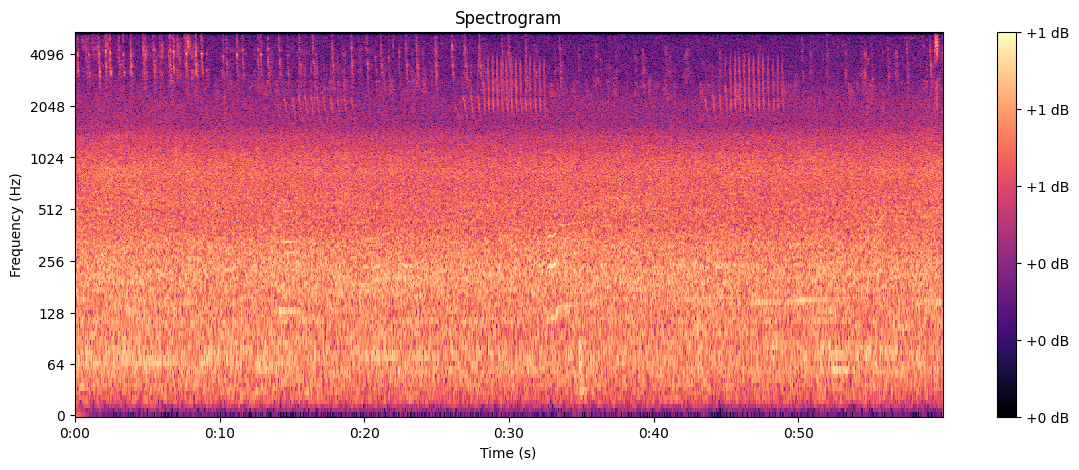

In [71]:
audio_file_path = os.path.expanduser(audio_file_path)
x, sr = librosa.load(audio_file_path, sr=11025)

#STFT (Short-Time Fourier Transform)
stft = librosa.stft(x)

spectrogram = librosa.amplitude_to_db(abs(stft))

spec_shifted = spectrogram - spectrogram.min()

spec_normalized = (spec_shifted - spec_shifted.min()) / (spec_shifted.max() - spec_shifted.min())

plt.figure(figsize=(14, 5))
librosa.display.specshow(spec_normalized, sr=sr, x_axis='time', y_axis='log', cmap='magma')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.show()

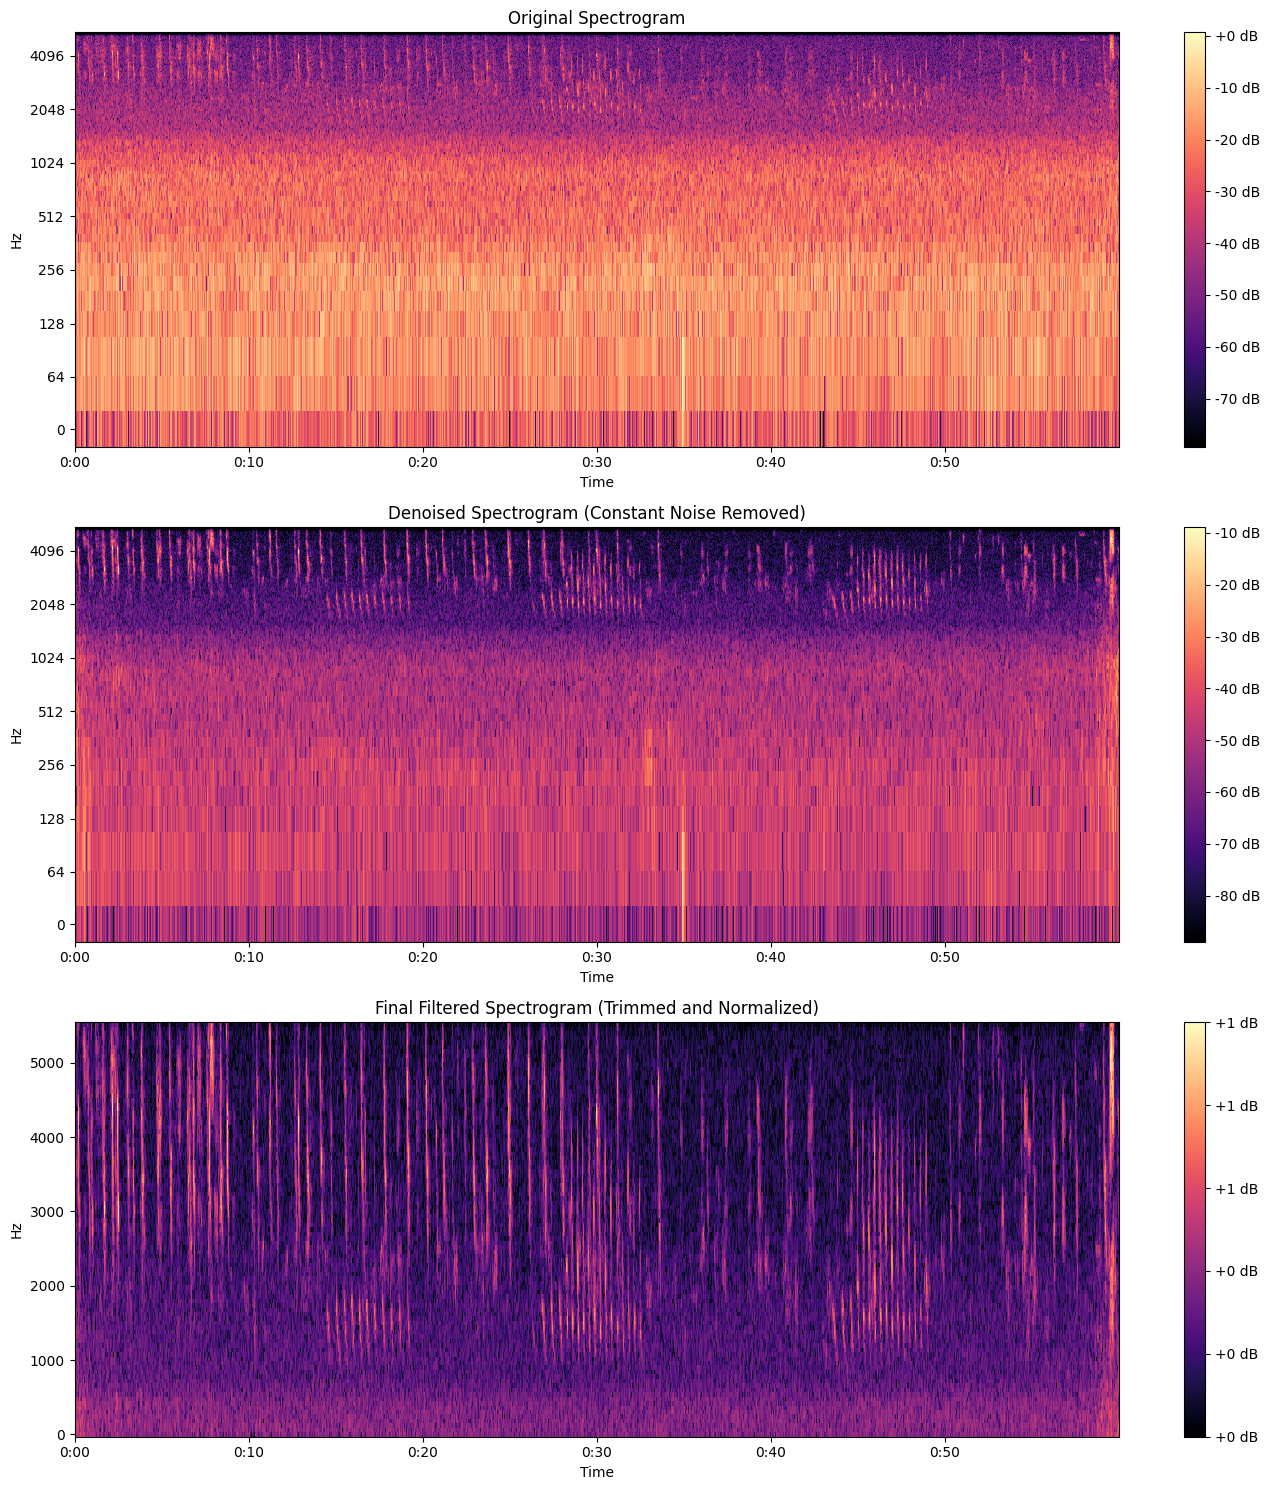

In [ ]:
noise_profile = x 
denoised_audio = nr.reduce_noise(y=x, sr=sr, y_noise=noise_profile, prop_decrease=0.95)
n_fft = 256  
hop_length = n_fft  


def detect_constant_frequencies(audio, sr, duration=10):
    stft = librosa.stft(audio, n_fft=n_fft, hop_length=hop_length)
    magnitude = np.abs(stft)
    freq_bins, time_frames = magnitude.shape

    average_magnitude = np.mean(magnitude, axis=1)

    threshold = 0.7 * np.max(average_magnitude)  # Adjust threshold as needed
    constant_freqs = np.where(average_magnitude > threshold)[0]

    frequencies = librosa.fft_frequencies(sr=sr, n_fft=n_fft)
    detected_frequencies = frequencies[constant_freqs]
    return detected_frequencies

constant_frequencies = detect_constant_frequencies(denoised_audio, sr)

def apply_notch_filters(audio, frequencies, sr, quality=30):
    filtered_audio = audio
    for freq in frequencies:
        w0 = freq / (0.5 * sr)  
        b, a = iirnotch(w0, quality)
        filtered_audio = filtfilt(b, a, filtered_audio)
    return filtered_audio

filtered_denoised_audio = apply_notch_filters(denoised_audio, constant_frequencies, sr)

def butter_bandpass(lowcut, highcut, fs, order=6):
    nyquist = 0.5 * fs  
    low = lowcut / nyquist  
    high = highcut / nyquist 
    b, a = butter(order, [low, high], btype='band')
    return b, a

def apply_bandpass_filter(data, lowcut, highcut, fs, order=6):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)  
    return y

lowcut = 1024 
highcut = 5000  
final_filtered_audio = apply_bandpass_filter(filtered_denoised_audio, lowcut, highcut, sr, order=6)

def trim_spectrogram_to_frequency_range(spectrogram, sr, lowcut, highcut, n_fft):
    frequencies = librosa.fft_frequencies(sr=sr, n_fft=n_fft)
    lowcut = max(lowcut, frequencies[0])  
    highcut = min(highcut, frequencies[-1]) 
    freq_indices = np.where((frequencies >= lowcut) & (frequencies <= highcut))[0]
    if len(freq_indices) == 0:
        raise ValueError(f"No valid frequencies in range {lowcut}-{highcut} for n_fft={n_fft} and sr={sr}")
    return spectrogram[freq_indices, :]

stft_final = librosa.stft(final_filtered_audio, n_fft=n_fft, hop_length=hop_length)
spectrogram_final = librosa.amplitude_to_db(np.abs(stft_final))

trimmed_spectrogram = trim_spectrogram_to_frequency_range(spectrogram_final, sr, lowcut, highcut, n_fft)

spec_shifted = trimmed_spectrogram - trimmed_spectrogram.min()
spec_normalized = spec_shifted / (spec_shifted.max() - spec_shifted.min())




final_audio_path = "final_filtered_audio.wav"
write(final_audio_path, sr, (final_filtered_audio * 32767).astype("int16"))
















plt.figure(figsize=(14, 15))
plt.subplot(3, 1, 1)
stft_original = librosa.stft(x, n_fft=n_fft, hop_length=hop_length)
spectrogram_original = librosa.amplitude_to_db(np.abs(stft_original))
librosa.display.specshow(spectrogram_original, sr=sr, x_axis='time', y_axis='log', cmap='magma', hop_length=hop_length)
plt.colorbar(format='%+2.0f dB')
plt.title('Original Spectrogram')

plt.subplot(3, 1, 2)
stft_denoised = librosa.stft(filtered_denoised_audio, n_fft=n_fft, hop_length=hop_length)
spectrogram_denoised = librosa.amplitude_to_db(np.abs(stft_denoised))
librosa.display.specshow(spectrogram_denoised, sr=sr, x_axis='time', y_axis='log', cmap='magma', hop_length=hop_length)
plt.colorbar(format='%+2.0f dB')
plt.title('Denoised Spectrogram (Constant Noise Removed)')

plt.subplot(3, 1, 3)
librosa.display.specshow(spec_normalized, sr=sr, x_axis='time', y_axis='linear', cmap='magma', hop_length=hop_length)
plt.colorbar(format='%+2.0f dB')
plt.title('Final Filtered Spectrogram (Trimmed and Normalized)')

plt.tight_layout()
plt.show()

### I have smoothed the SPEC using a gaussian filter to reduce noisiness, It might be usefull (or might not) 

In [ ]:

spec_gauss = gaussian_filter(spec, sigma=1)

fig = go.Figure(
    data=go.Heatmap(
        z=spec_gauss,
        colorscale="Viridis",
        colorbar=dict(title="Log-Scaled"),
    )
)

fig.update_layout(
    font=dict(size=18),
    title={
        "text": f"Spectrogram noise-reduced (Sample {random_idx})<br>Bird Species: {', '.join(present_species)}",
        "x": 0.5,
        "xanchor": "center",
    },
    xaxis=dict(title="Time (frames)"),
    yaxis=dict(title="Frequency"),
)

fig.show()


In [ ]:

# Define a threshold for noise removal (e.g., remove values below 0.1)
threshold = 0.5
spec_denoised = np.copy(spec_gauss)
spec_denoised[spec_denoised < threshold] = 0  # Mask low-intensity values

fig = go.Figure(
    data=go.Heatmap(
        z=spec_denoised,
        colorscale="Viridis",
        colorbar=dict(title="Log-Scaled"),
    )
)

fig.update_layout(
    font=dict(size=18),
    title={
        "text": f"Spectrogram noise-reduced (Sample {random_idx})<br>Bird Species: {', '.join(present_species)}",
        "x": 0.5,
        "xanchor": "center",
    },
    xaxis=dict(title="Time (frames)"),
    yaxis=dict(title="Frequency"),
)

fig.show()

### Extracting features such as spectral centroid

In [ ]:


spectral_centroid = librosa.feature.spectral_centroid(S=np.abs(spec))

fig = go.Figure(
    data=go.Heatmap(
        z=spectral_centroid,
        colorscale="Viridis",
        colorbar=dict(title="Log-Scaled"),
    )
)

fig.update_layout(
    font=dict(size=18),
    title={
        "text": f"Spectrogram (Sample {random_idx})<br>Bird Species: {', '.join(present_species)}",
        "x": 0.5,
        "xanchor": "center",
    },
    xaxis=dict(title="Time (frames)"),
    yaxis=dict(title="Frequency"),
)

fig.show()

### I have plotted 3d view of SPEC (Fixed/Interactive) Usefull for report later

In [ ]:
X, Y = np.meshgrid(range(spec.shape[1]), range(spec.shape[0]))
Z = spec

fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap='viridis')
ax.set_xlabel('Time Frames')
ax.set_ylabel('Frequency Bins')
ax.set_zlabel('Log Amplitude')
plt.show()

In [ ]:
fig = go.Figure(data=[go.Surface(z=Z, x=X, y=Y, colorscale='Viridis')])
fig.update_layout(
    title="3D Spectrogram Visualization",
    scene=dict(
        xaxis_title='Time Frames',
        yaxis_title='Frequency Bins',
        zaxis_title='Amplitude',
        zaxis=dict(nticks=5),
    ),
)

fig.show()

In [ ]:
species_summary = {species: [] for species in species_labels}
species_summary["Location"] = []

for location in locations:
    labels_file = os.path.join(root_dir, location, "train_labels.csv")
    labels_df = pd.read_csv(labels_file)
    labels_df['location'] = location
    species_counts = labels_df[species_labels].sum(axis=0).tolist()
    
    for i, species in enumerate(species_labels):
        species_summary[species].append(species_counts[i])
    species_summary["Location"].append(location)

species_summary_df = pd.DataFrame(species_summary)

overall_counts = species_summary_df[species_labels].sum(axis=0).tolist()  
overall_row = {"Location": "Overall"} 
overall_row.update({species: count for species, count in zip(species_labels, overall_counts)}) 
species_summary_df = pd.concat([species_summary_df, pd.DataFrame([overall_row])], ignore_index=True)
species_summary_df

AMRO  BHCO  CHSW  EUST  GRCA  HOSP  HOWR  NOCA  RBGU  RWBL Location
0    128    14    60    61     1   129    16    35    25    36      BRY
1    205    43    67    64    26   158    89    96     6    31      CAL
2    157     8    31    98    22   158    54    62    12    70      FIO
3    229    32    73   101     8   105    55   101    10    69      HAR
4    167    35    45    89    34   171    36    89     4    22      KEA
5    179    25   123    68     1   134    79    45    22     4      LAW
6    215    33    81    78     5   158   103   109    21     0      LIF
7    158    25    43    77    44   132    35    29    43     0      MCK
8    194    11   193    92     1   163    25    32    30     1      PEN
9    201    36   104    55    24    85    22    72    17     0      SYL
10    73    30    40    54     0   103     4    45    93    42      WAT
11  1906   292   860   837   166  1496   518   715   283   275  Overall

In [ ]:
species_columns = species_summary_df.columns[:-1]  # no 'Location'
species_sums = species_summary_df[species_columns].sum()  #  bird type count 
colors = plt.cm.tab20(np.linspace(0, 1, len(species_columns)))  

fig, ax = plt.subplots(figsize=(10, 10))
ax.set_aspect('equal')

main_circle = plt.Circle((0, 0), 2, color='lightgrey', alpha=0.3, label='Total Data')
ax.add_artist(main_circle)

for species, count, color in zip(species_columns, species_sums, colors):
    radius = np.sqrt(count) / 50 
    angle = list(species_columns).index(species) * (2 * np.pi / len(species_columns))
    x = np.cos(angle) * 2
    y = np.sin(angle) * 2
    small_circle = plt.Circle((x, y), radius, color=color, alpha=0.7, label=species)
    ax.add_artist(small_circle)
    ax.text(x, y, f"{species}\n{count}", ha='center', va='center', fontsize=8)

ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
ax.axis('off')
ax.legend(loc='upper right', fontsize=8, bbox_to_anchor=(1.3, 1.1))
plt.show()
